In [1]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

The ... det
22-year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


In [2]:
doc = nlp("Nagal won the first set.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


In [3]:
!wget https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/wiki_sentences_v2.csv

--2020-04-07 11:39:27--  https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/wiki_sentences_v2.csv
Resolving cdn.analyticsvidhya.com (cdn.analyticsvidhya.com)... 104.26.14.185, 104.26.15.185, 2606:4700:20::681a:fb9, ...
Connecting to cdn.analyticsvidhya.com (cdn.analyticsvidhya.com)|104.26.14.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 275069 (269K) [text/csv]
Saving to: ‘wiki_sentences_v2.csv’

wiki_sentences_v2.c 100%[===================>] 268.62K  --.-KB/s    in 0.04s   

2020-04-07 11:39:27 (6.68 MB/s) - ‘wiki_sentences_v2.csv’ saved [275069/275069]



In [0]:
#Importing the libraries
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [5]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [6]:
candidate_sentences['sentence'].sample(5)

1069                                                                                    in some cases the destruction was proactive.
3661                                                                   jack nicholson had been uslan's and kane's choice since 1980.
2696    fargo is a 1996 british-american neo-noir black comedy thriller film written, produced, and directed by joel and ethan coen.
1297                                      le grandi medaglie d’oro dell’associazione nazionale fascista dello spettacolo in italian.
3333                                                                   the following sortable table shows the corresponding numbers.
Name: sentence, dtype: object

In [0]:
def get_entities(sent):
  ## chunk 1
   ent1 = ""
   ent2 = ""

   prv_tok_dep = ""    # dependency tag of previous token in the sentence
   prv_tok_text = ""   # previous token in the sentence

   prefix = ""
   modifier = ""

   for tok in nlp(sent):
     # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = "" 

     ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

    ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

   return [ent1.strip(), ent2.strip()]

In [9]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [10]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:44<00:00, 98.05it/s]


In [11]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

In [0]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [13]:
get_relation("John completed the task")

'completed'

In [14]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:41<00:00, 103.59it/s]


In [15]:
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
are               71
were              71
released          40
's                38
composed by       35
has               31
have              31
became            31
become            29
released in       27
included          26
produced          22
called            22
considered        20
made              20
had               20
been              18
be                18
used              17
scheduled         17
directed by       16
stars             16
written by        15
wrote             14
hired             14
produced by       14
set               14
received          13
went              13
introduced in     13
wanted            12
won               11
began             11
began in          11
sold              10
features          10
gave              10
known as           9
includes           9
shot in            9
produced in        9
opened             9
reported           9
used in      

In [0]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [0]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

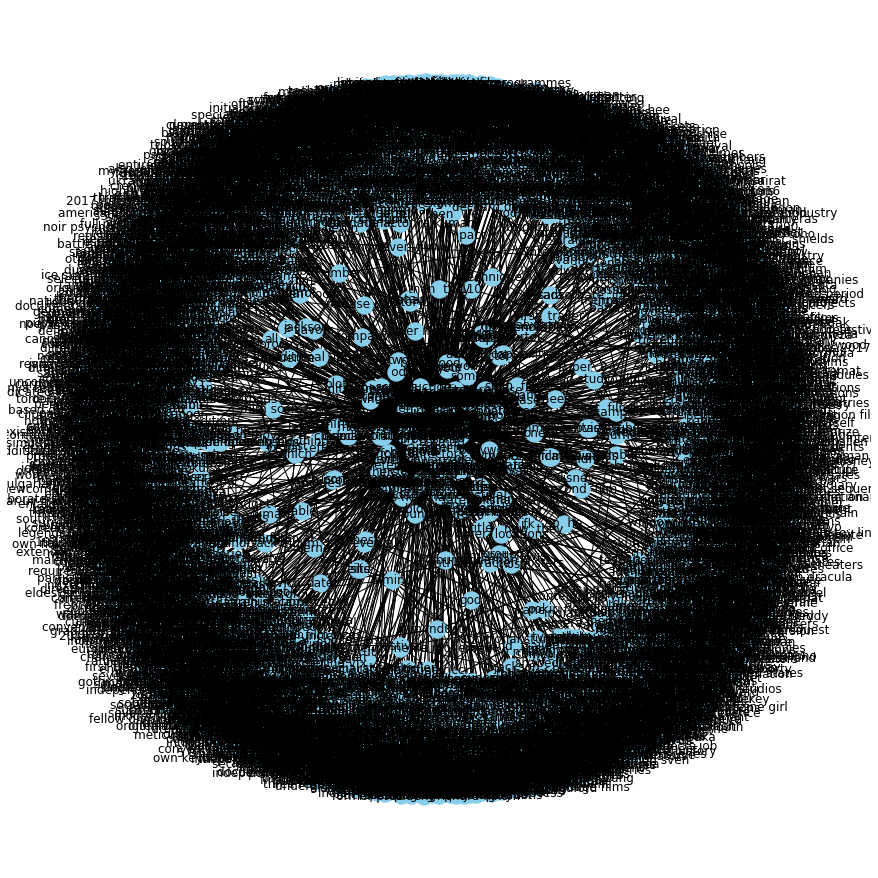

In [18]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

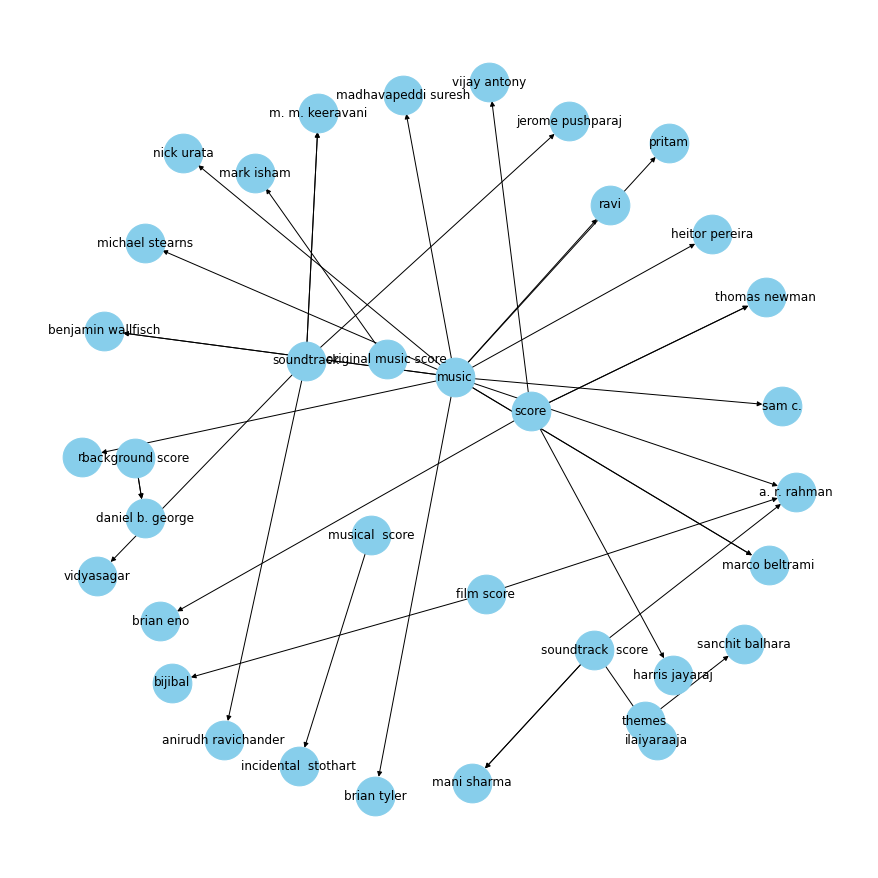

In [19]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

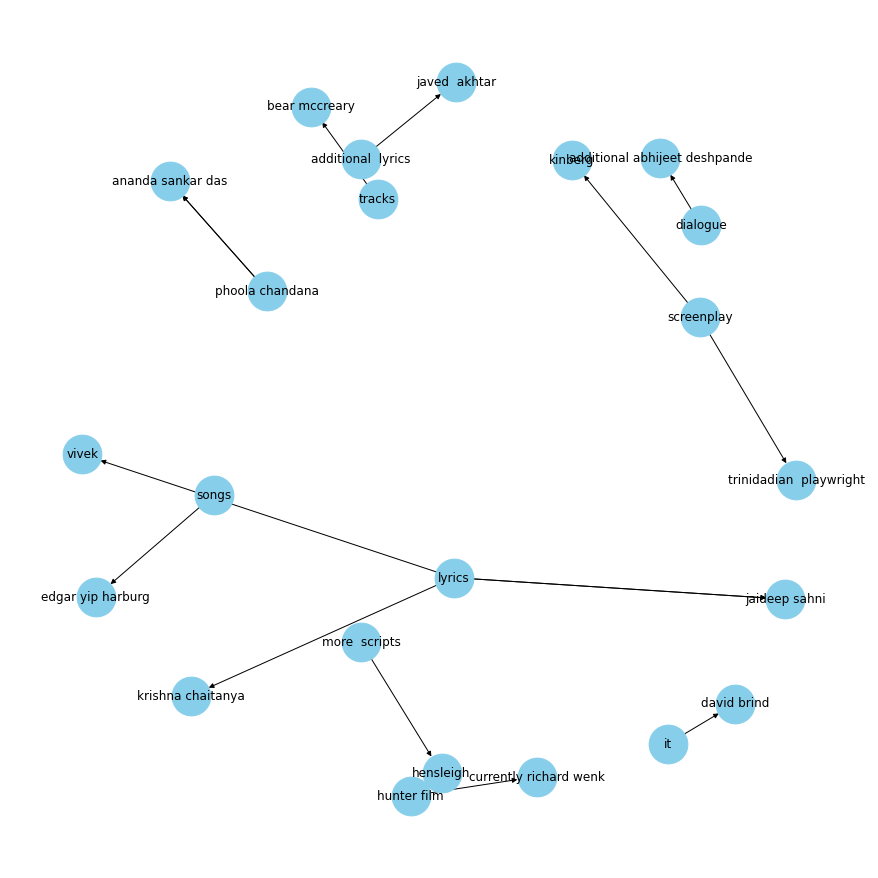

In [20]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

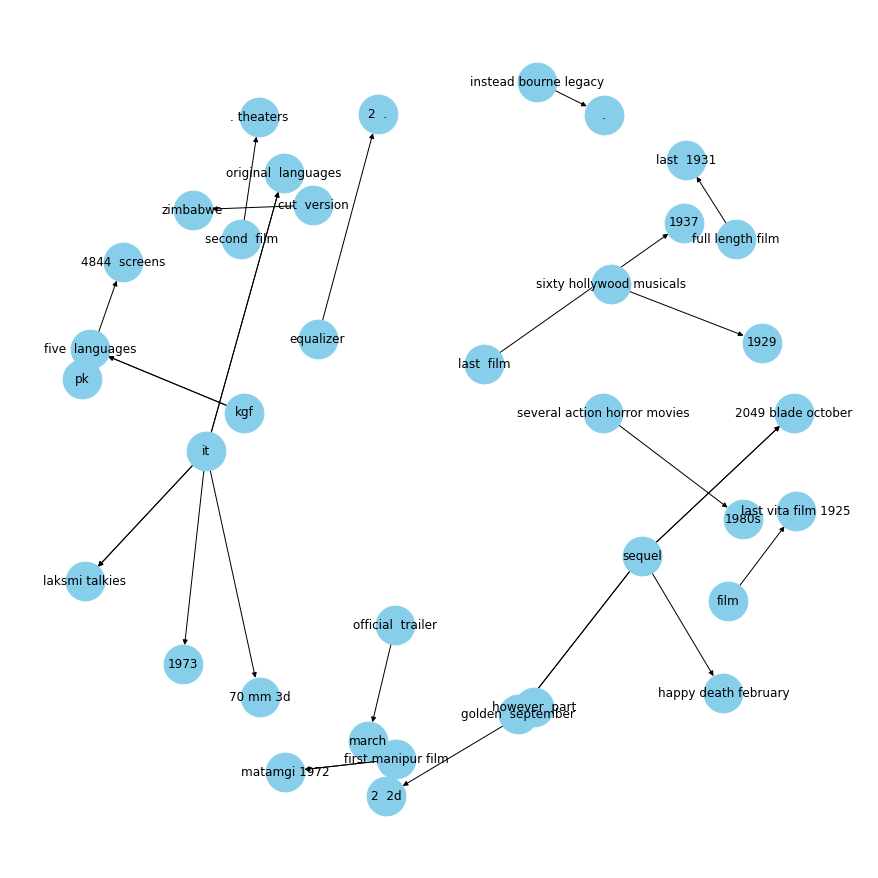

In [21]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()